In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Gets a theoretical prediction for the noise
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


# Masks Stuff

In [16]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

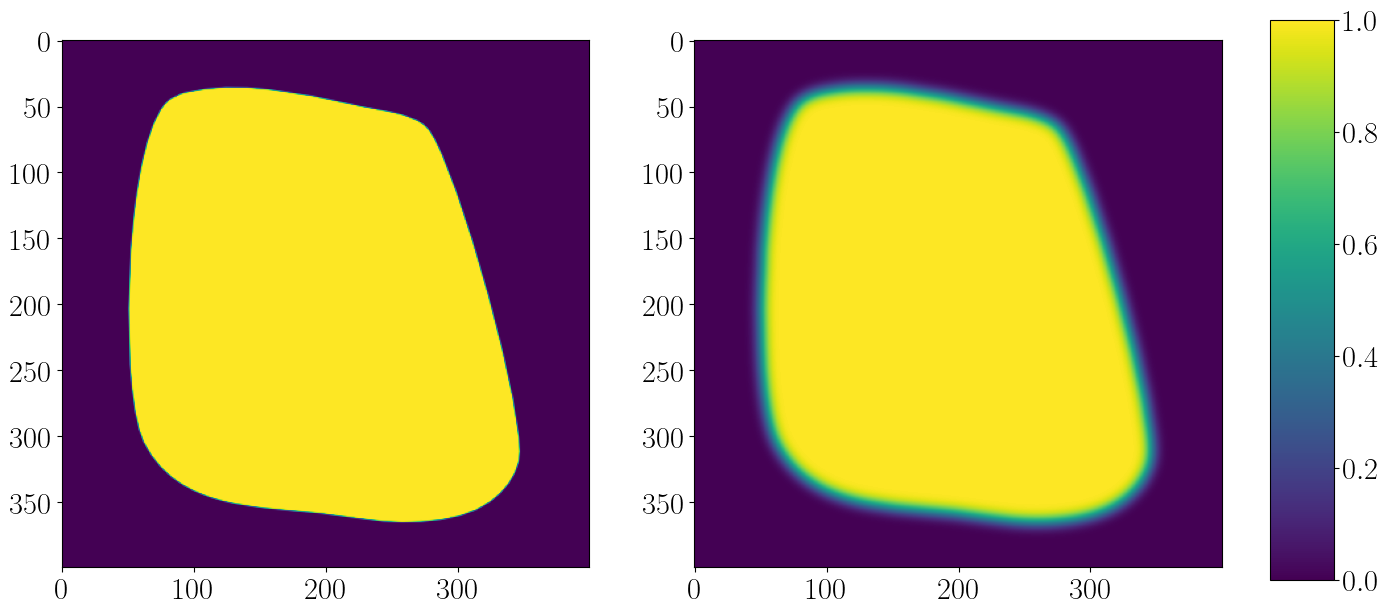

In [77]:
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = 1-rgb2gray(plt.imread('../data/input/mask_simple400x400.png'))
apodized_mask = gaussian_filter(mask, 5)
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

im0 = axs[0].imshow(mask, vmin=0, vmax=1)
im1 = axs[1].imshow(apodized_mask, vmin=0, vmax=1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax)

# Testing on simulated CMB Map
Basically the next cells do the following
1. Generates a gaussain random field with the same power spectrum as the unlensed CMB. This will be a "realization" of the CMB
2. Generates a gaussain random field with teh same power spectrum as "kappa" in a universe? TODO wjat. This will be a specific realization of "kappa", e.g. we fix kappa
3. Lens our simulated CMB with our simulated Kapppa 
4. Generated gaussian random field with same power spectrum as we expect from detector noise and add this to our lensed CMB

/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:42: RuntimeWarning: invalid value encountered in double_scalars
  self.funlensedTT = lambda l: (l>=lmin_unlensedCMB and l<=lmax_unlensedCMB) * self.funlensedTT_template(l) * self.fdl_to_cl(l)


Generate GRF unlensed CMB map (debeamed)
plot unlensed CMB map


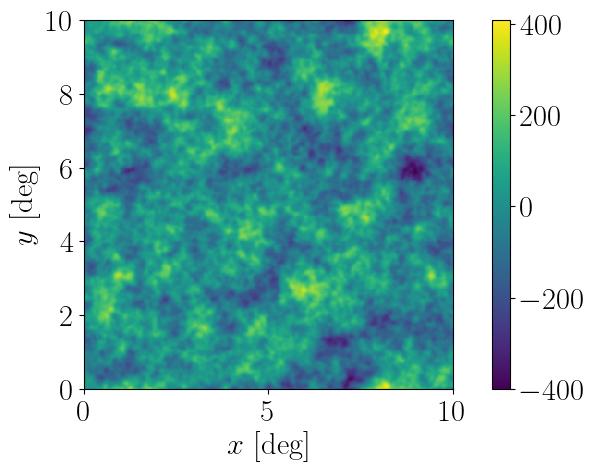

check the power spectrum


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:462: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


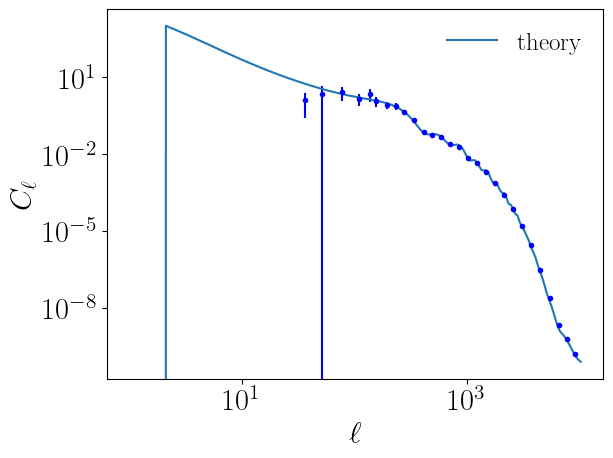

In [8]:
print("Generate GRF unlensed CMB map (debeamed)")

#generate GRF with the same power spectrum as the unlensed CMB
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)
print("plot unlensed CMB map")
baseMap.plot(cmb0)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(cmb0Fourier, theory=[cmb.funlensedTT], plot=True, save=False)

Generate GRF kappa map
plot kappa map


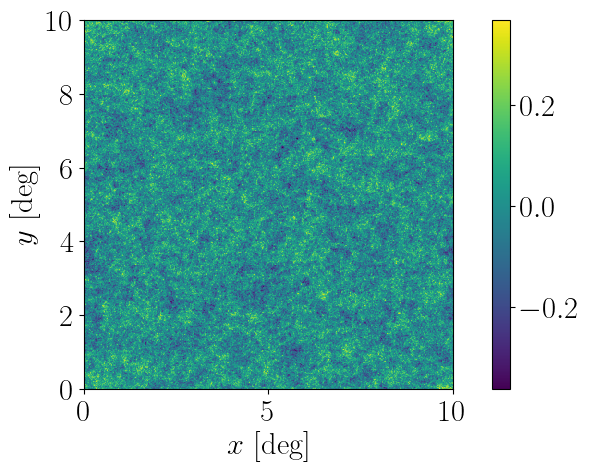

check the power spectrum


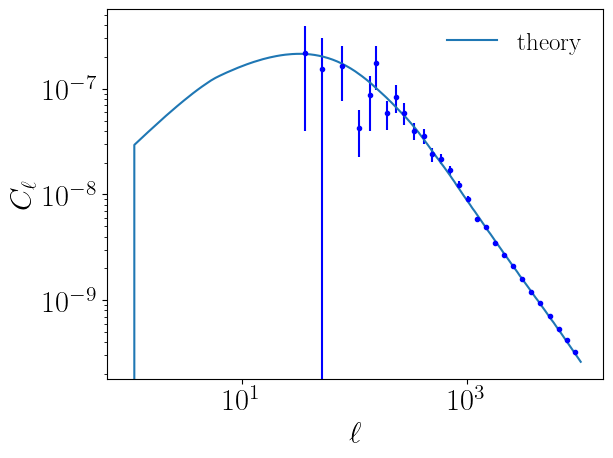

In [9]:
print("Generate GRF kappa map")

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)
print("plot kappa map")
baseMap.plot(kCmb)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(kCmbFourier, theory=[p2d_cmblens.fPinterp], plot=True, save=False)

Lens the CMB map


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1208: RuntimeWarning: invalid value encountered in divide
  dxFourier = -2.j * self.lx/self.l**2 * kappaFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1209: RuntimeWarning: invalid value encountered in divide
  dyFourier = -2.j * self.ly/self.l**2 * kappaFourier


plot lensed CMB map


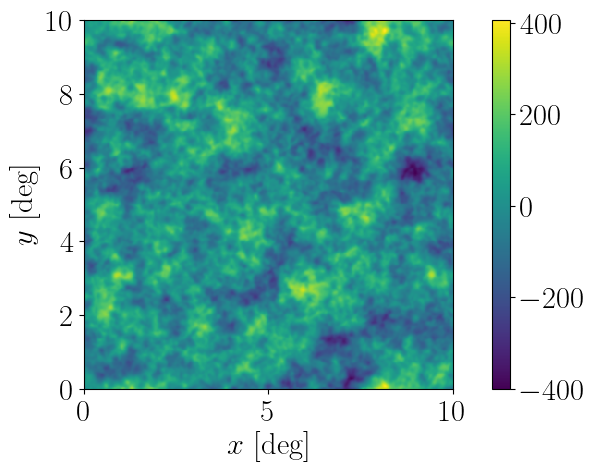

check the power spectrum


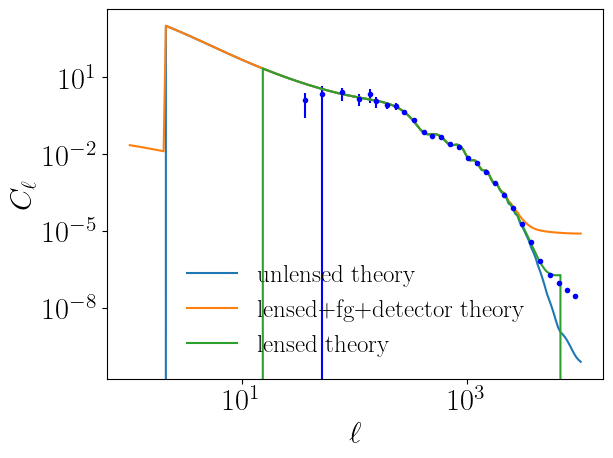

In [10]:
print("Lens the CMB map")

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)
print("plot lensed CMB map")
baseMap.plot(lensedCmb, save=False)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(lensedCmbFourier, 
                                      theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+fg+detector', 'lensed'],
                                      plot=True, save=False)

Generate FG map


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:290: RuntimeWarning: invalid value encountered in double_scalars
  return a_CIBP * (l/3000.)**2 * self.mu(nu1, betaP, Td)*self.mu(nu2, betaP, Td)/self.mu(150.e9, betaP, Td)**2 * self.fdl_to_cl(l)
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:301: RuntimeWarning: invalid value encountered in double_scalars
  return a_CIBC * (l/3000.)**(2-n) * self.mu(nu1, betaC, Td)*self.mu(nu2, betaC, Td)/self.mu(150.e9, betaC, Td)**2 * self.fdl_to_cl(l)
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:114: RuntimeWarning: invalid value encountered in double_scalars
  self.ftSZ = lambda l: (l>=lmin_tSZ and l<=lmax_tSZ) * a_tSZ * self.freqDpdceTSZTemp(self.nu1)*self.freqDpdceTSZTemp(self.nu2)/self.freqDpdceTSZTemp(150.e9)**2 * ftSZ_templa

plot lensed+FG CMB map


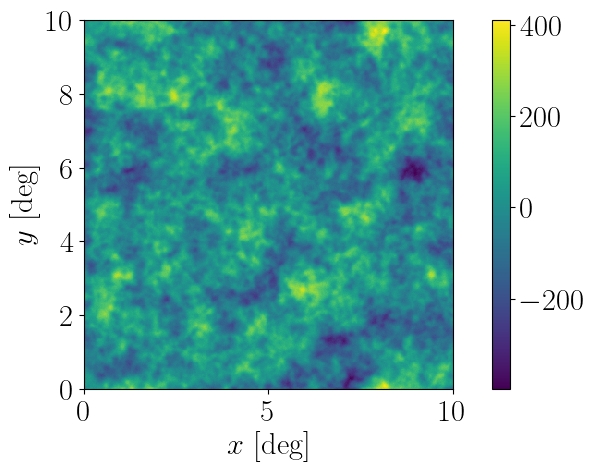

check the power spectrum


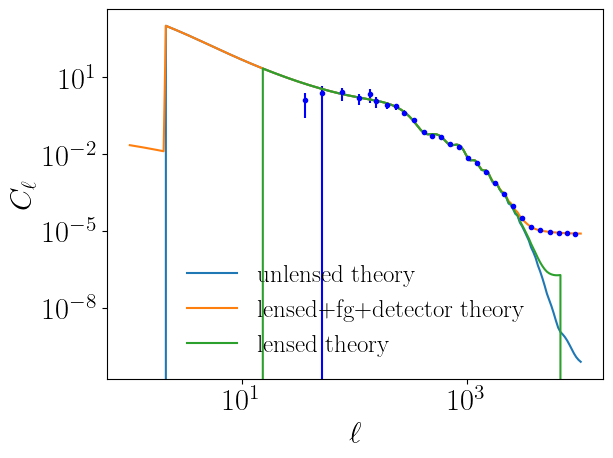

In [11]:
print("Generate FG map")

fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)
print("plot lensed+FG CMB map")
baseMap.plot(lensedCmb, save=False)

print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(lensedCmbFourier, 
                                      theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+fg+detector', 'lensed'],
                                      plot=True, save=False)

Add white detector noise (debeamed)


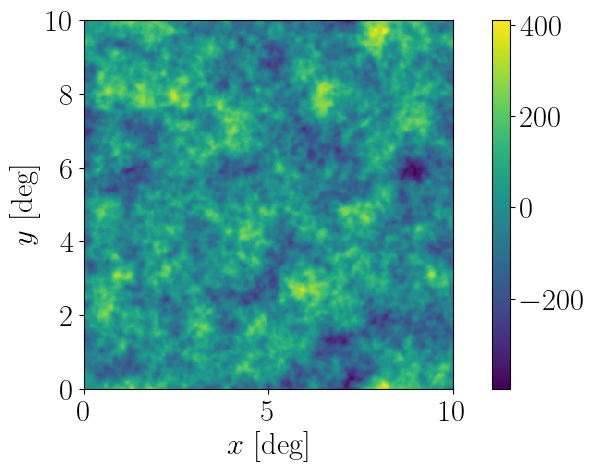

check the power spectrum


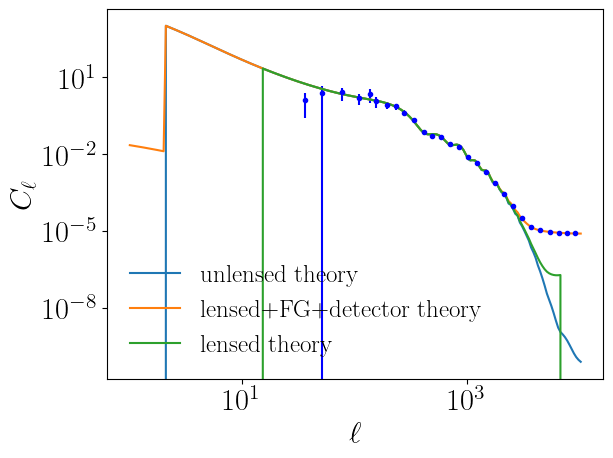

In [86]:
print("Add white detector noise (debeamed)")

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)
baseMap.plot(totalCmb)
print("check the power spectrum")
lCent, Clt, sClt = baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+FG+detector', 'lensed'],
                                          plot=True, save=False)

Masking the map


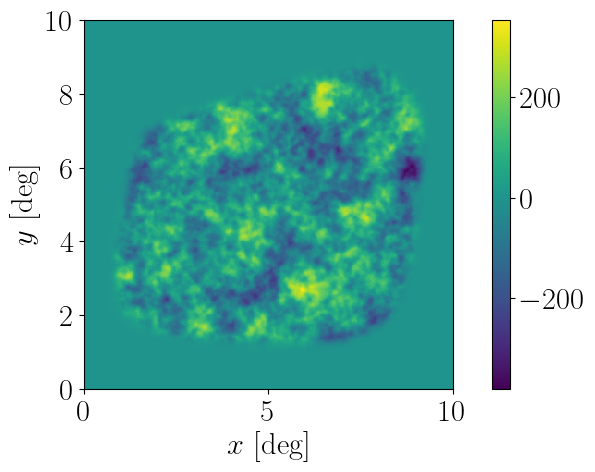

check the power spectrum


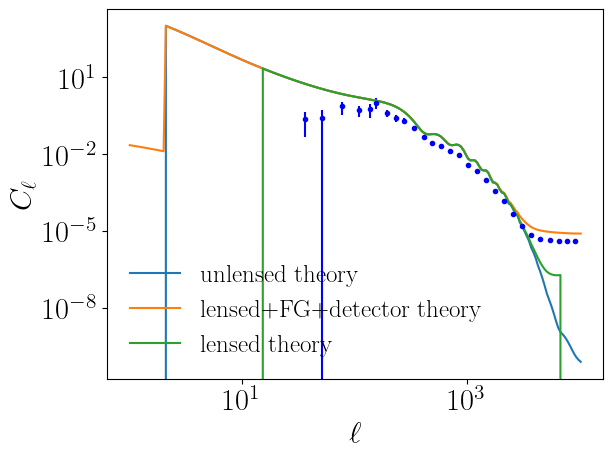

looking for maksed power spectrum


In [100]:
print("Masking the map")

totalMaskedCmb = apodized_mask*totalCmb
totalMaskedCmbFourier = baseMap.fourier(totalMaskedCmb)
baseMap.plot(totalMaskedCmb)

print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(totalMaskedCmbFourier,theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+FG+detector', 'lensed'],
                                          plot=True, save=False)
print('looking for maksed power spectrum')
assert(all(lCen==lCent))
maskCl = Cl-Clt

# Applying QE to our simulated data

In [107]:
data = {}
Cls = {}
funcs = dict(zip(['Standard QE', 'AFC Eq(7)'], 
                 [baseMap.computeQuadEstKappaNorm, 
                  baseMap.computeQuadEstKappaAutoCorrectionMap]))
nG = dict(zip(['Standard QE', 'AFC Eq(7)'], 
                 [False, 
                  False]))
for key in funcs:
    data[key] = funcs[key](cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                       dataFourier=totalMaskedCmbFourier, test=False)


    Cls[key] = baseMap.powerSpectrum(dataFourier=data[key],
                                          theory=[p2d_cmblens.fPinterp, fNqCmb_fft], 
                                          theory_l=['TODO ask p2d?', 'QE'],
                                          plot=False, save=False, notGaussian=nG[key])

Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:462: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:2345: RuntimeWarning: invalid value encountered in sqrt
  resultFourier = np.sqrt(np.real(resultFourier))


In [108]:
Cls['(Auto QE)-(Power Spectrum(hat NL))'] = (Cls['Standard QE'][0], #binning same 
                                            Cls['Standard QE'][1] - Cls['AFC Eq(7)'][1], #subtract power spectrums 
                                            Cls['Standard QE'][2]) #TODO how do i get error bars?

/tmp/ipykernel_3018563/3136184572.py:59: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))


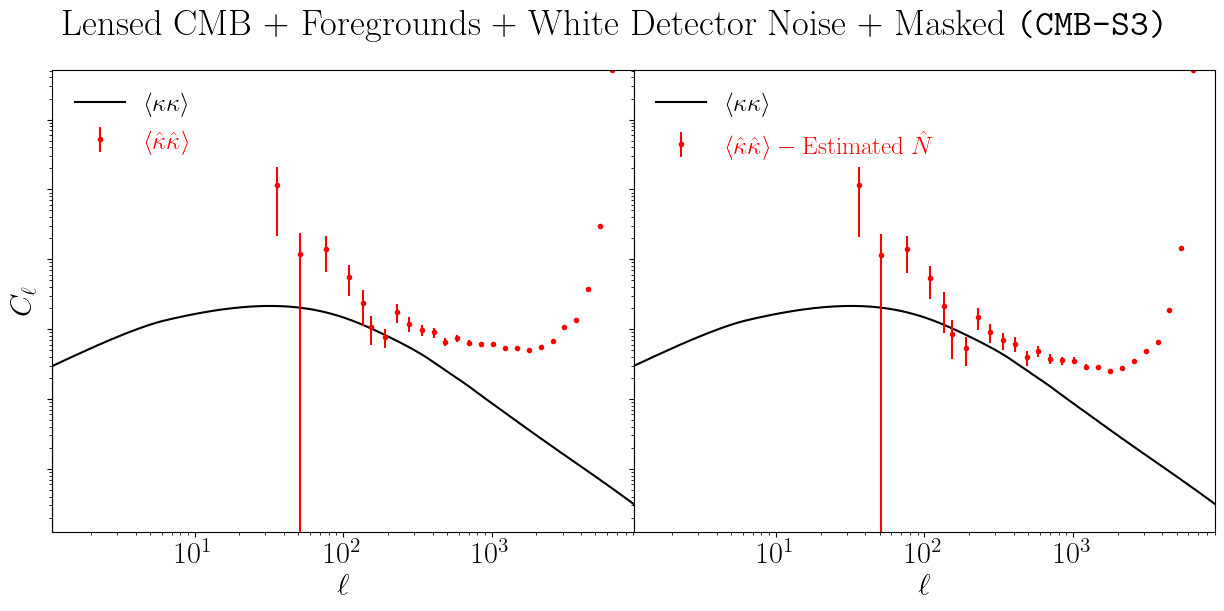

In [110]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

ell = baseMap.l.flatten()
factor = 1. # lCen**2

labels ={'Standard QE': r'${\big<\hat \kappa \hat\kappa \big>}$',
         'AFC Eq(7)': r'Computed noise $\hat N$',
         '(Auto QE)-(Power Spectrum(hat NL))': r'${\big<\hat \kappa \hat\kappa \big>- \textrm{Estimated }\hat N}$',
    
}
ax_idx ={'Standard QE': 0,
         'AFC Eq(7)': 1,
         '(Auto QE)-(Power Spectrum(hat NL))': 1,
    
}

theory=[p2d_cmblens.fPinterp, fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$']#, r'Projected noise $N$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, factor*ClExpected, sty, label=l)

bnds = {'x':[],'y':[]}
for key in Cls:
    if(key=='AFC Eq(7)'):
        continue
    lCen, Cl, sCl = Cls[key]

    Ipos = np.where(Cl>=0.)
    Ineg = np.where(Cl<0.)

    ax = axs[ax_idx[key]]
    fctr = factor
    if(key=='AFC Eq(7)'):
        fctr = 0
    ax.errorbar(lCen[Ipos], factor*(Cl[Ipos]), yerr=fctr*sCl[Ipos], c='red',fmt='.', label=labels[key])
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    if(ax_idx[key]==0):
        ax.set_ylabel(r'$C_\ell$')
    else:
        ax.set_yticklabels([])
        
        
    bnds['x'] += [np.min(lCen), np.max(lCen)]
    bnds['y'] += [factor*np.min(Cl), factor*np.max(Cl)]
    

fig.suptitle(r'Lensed CMB + Foregrounds + White Detector Noise + Masked \texttt{(CMB-S3)}')

for ax in axs:
    ax.set_xlim(np.min(bnds['x']), np.max(bnds['x']))
    ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))


    
    l=ax.legend(frameon=False, loc='upper left')
    l.get_texts()[-1].set_color('red')



plt.savefig('figures/Cl_compare.png', bbox_inches='tight')

# everything below basically trash
.

.

.

.

.

.

---

# Detector noise important? AKA testing vs cross of two measurements

In [16]:
def genTestMap(Cl0, lCl=None, dCl=None, n_detector_runs=1):
    cmb0Fourier = baseMap.genGRF(Cl0, test=False)
    cmb0 = baseMap.inverseFourier(cmb0Fourier)
    
    kCmbFourier = baseMap.genGRF(lCl, test=False)
    kCmb = baseMap.inverseFourier(kCmbFourier)
    
    lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
    lensedCmbFourier = baseMap.fourier(lensedCmb)
    
    totalCmb = []
    totalCmbFourier = []
    for i in range(n_detector_runs):
        noiseFourier = baseMap.genGRF(dCl, test=False)
        print(noiseFourier)
        totalCmbFourier += [lensedCmbFourier + noiseFourier]
        totalCmb += [baseMap.inverseFourier(totalCmbFourier)]

    keys = ['total', 'lensed', 'unlensed']
    maps = dict(zip(keys, [totalCmb, lensedCmb, cmb0]))
    mapsFourier = dict(zip(keys, [totalCmbFourier, lensedCmbFourier, cmb0Fourier]))
    
    return maps, mapsFourier

In [17]:
maps, mapsFourier = genTestMap(cmb.funlensedTT,
                               lCl=p2d_cmblens.fPinterp,
                               dCl=cmb.fdetectorNoise)

/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:42: RuntimeWarning: invalid value encountered in double_scalars
  self.funlensedTT = lambda l: (l>=lmin_unlensedCMB and l<=lmax_unlensedCMB) * self.funlensedTT_template(l) * self.fdl_to_cl(l)


[[ 4.08312587e-05+0.00000000e+00j -1.85901285e-06-7.34768295e-05j
   6.13581442e-05-5.32926028e-05j ... -1.90040021e-06+9.64117012e-05j
  -1.21173042e-05-5.25470469e-05j -2.94509581e-05+0.00000000e+00j]
 [ 2.20587711e-05+5.68012275e-05j -2.31979489e-05-1.30233169e-05j
   1.53614308e-05-1.66202705e-05j ... -1.33361385e-06-4.51535027e-05j
   7.42551658e-06+3.50526186e-05j -9.08518262e-05+2.02477243e-05j]
 [ 6.45751457e-05-2.00995830e-07j -6.57787553e-05+4.96548630e-05j
   3.14408408e-05+8.20269287e-05j ... -4.09873054e-05-2.75531098e-06j
   1.34792493e-04+5.18746197e-05j  4.73404117e-07-9.99239327e-07j]
 ...
 [-1.21555796e-05+2.52762622e-05j  3.51298351e-05+3.59006785e-05j
   3.35174033e-05-1.75487799e-05j ... -4.95753208e-05-2.93866565e-06j
  -3.79622625e-05-2.18918415e-05j  6.62452737e-05-1.30504757e-05j]
 [ 6.45751457e-05+2.00995830e-07j  2.13967414e-05-6.61793078e-05j
   1.46575693e-05+5.54375748e-06j ...  3.02524605e-05+1.54519718e-05j
  -7.83148013e-05+4.21742927e-06j  4.73404117e-

In [18]:
def applyQE(dataFourier, baseMap, AFC=True):
    standardQE = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                 dataFourier=dataFourier, test=False)
    standardCl = baseMap.powerSpectrum(dataFourier=standardQE,plot=False, save=False)
    Nhat = [0]*len(standardCl)
    if(AFC):
        tmp = baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                           dataFourier=dataFourier, test=False)
        Nhat = baseMap.powerSpectrum(dataFourier=tmp, plot=False, save=False)
    return  standardCl[0], standardCl[1]-Nhat[1], standardCl[2]

def crossEst(dataFouriers, baseMap):
    pairs = [(dataFouriers[0], dataFouriers[1]), (dataFouriers[2], dataFouriers[3])]
    standardQEs = [baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                 dataFourier=dataFourier1, dataFourier2=dataFourier2)
                  for (dataFourier1, dataFourier2) in pairs]
    standardCl = baseMap.crossPowerSpectrum(dataFourier1=standardQEs[0], dataFourier2=standardQEs[1])
    
    return standardCl

In [19]:
keys = ['With Detector', 'Without Detector']
mapsFourier['With Detector'] = mapsFourier['total'][0]
mapsFourier['Without Detector'] = mapsFourier['lensed']

Cls = {key: applyQE(mapsFourier[key], baseMap) for key in keys}

Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


/tmp/ipykernel_2799387/3562168071.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))


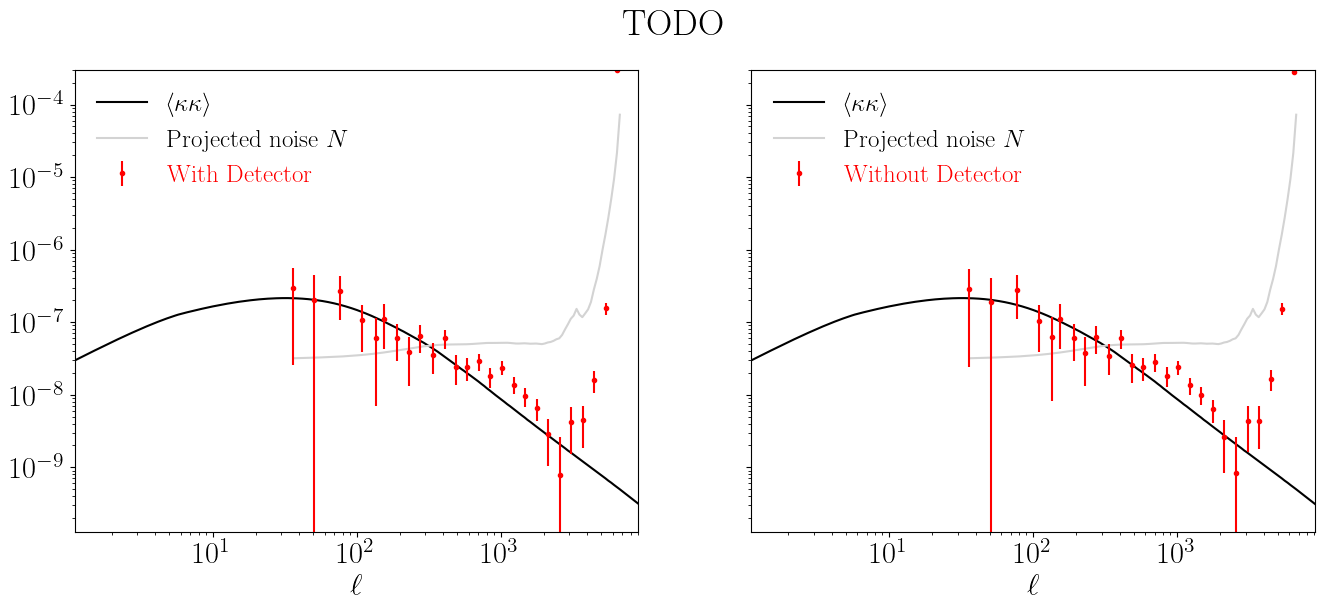

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6), sharey=True)
idxs = dict(zip(keys, [0,1]))

ell = baseMap.l.flatten()
factor = 1. # lCen**2

theory=[p2d_cmblens.fPinterp, fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$', r'Projected noise $N$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, factor*ClExpected, sty, label=l)

bnds = {'x':[],'y':[]}

for key in Cls:
    lCen, Cl, sCl = Cls[key]

    Ipos = np.where(Cl>=0.)
    Ineg = np.where(Cl<0.)
    
    fctr = factor
    ax = axs[idxs[key]]

    ax.errorbar(lCen[Ipos], factor*Cl[Ipos], yerr=factor*sCl[Ipos],c='red',fmt='.', label=key)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
        
        
    bnds['x'] += [np.min(lCen), np.max(lCen)]
    bnds['y'] += [factor*np.min(Cl), factor*np.max(Cl)]
    
fig.suptitle(r'TODO')

for ax in axs:
    ax.set_xlim(np.min(bnds['x']), np.max(bnds['x']))
    ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))


    
    l=ax.legend(frameon=False, loc='upper left')
    l.get_texts()[-1].set_color('red')

In [21]:
maps, mapsFourier = genTestMap(cmb.funlensedTT,
                               lCl=p2d_cmblens.fPinterp,
                               dCl=cmb.fdetectorNoise,
                              n_detector_runs=4)

[[ 1.08625666e-05+0.00000000e+00j -6.50235417e-05+3.03237576e-05j
   5.95791152e-07+1.44806806e-05j ... -5.77580012e-05-4.49240331e-05j
   6.04631630e-05+5.75103346e-05j  4.07535645e-05+0.00000000e+00j]
 [ 1.07174320e-05-4.78479440e-05j  5.45125300e-06-3.32042187e-05j
   7.70918469e-05+1.44376580e-05j ... -1.82462481e-06+3.96599722e-06j
   1.16873783e-05+4.44839579e-06j -2.71887142e-05-3.21117722e-06j]
 [ 7.77249606e-06-3.20680148e-05j  4.27618574e-05-3.14645804e-05j
  -8.35330962e-05-1.71478916e-05j ...  1.20967476e-05-4.50871348e-05j
   3.55514816e-05-4.43185546e-05j  1.63149126e-05-5.88721171e-05j]
 ...
 [-4.83825143e-05-6.76929738e-05j  8.11531741e-06-1.39937743e-06j
  -6.03631439e-05-1.81296413e-05j ...  5.57092357e-06+1.60541327e-05j
  -3.68729280e-05-2.31528031e-05j -3.05139094e-05+6.52617965e-05j]
 [ 7.77249606e-06+3.20680148e-05j  1.33480834e-05+9.00546748e-06j
   5.23010292e-05-7.12566435e-05j ...  5.03378117e-05+4.24259852e-05j
  -5.34403239e-05-6.75630665e-06j  1.63149126e-

In [22]:
Cls = {'measurement %d'%(i): applyQE(mapsFourier['total'][i], baseMap) for i in range(4)}

Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


In [23]:
Cls['cross'] = crossEst([mapsFourier['total'][i] for i in range(4)], baseMap)

Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


/tmp/ipykernel_2799387/1235222561.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))


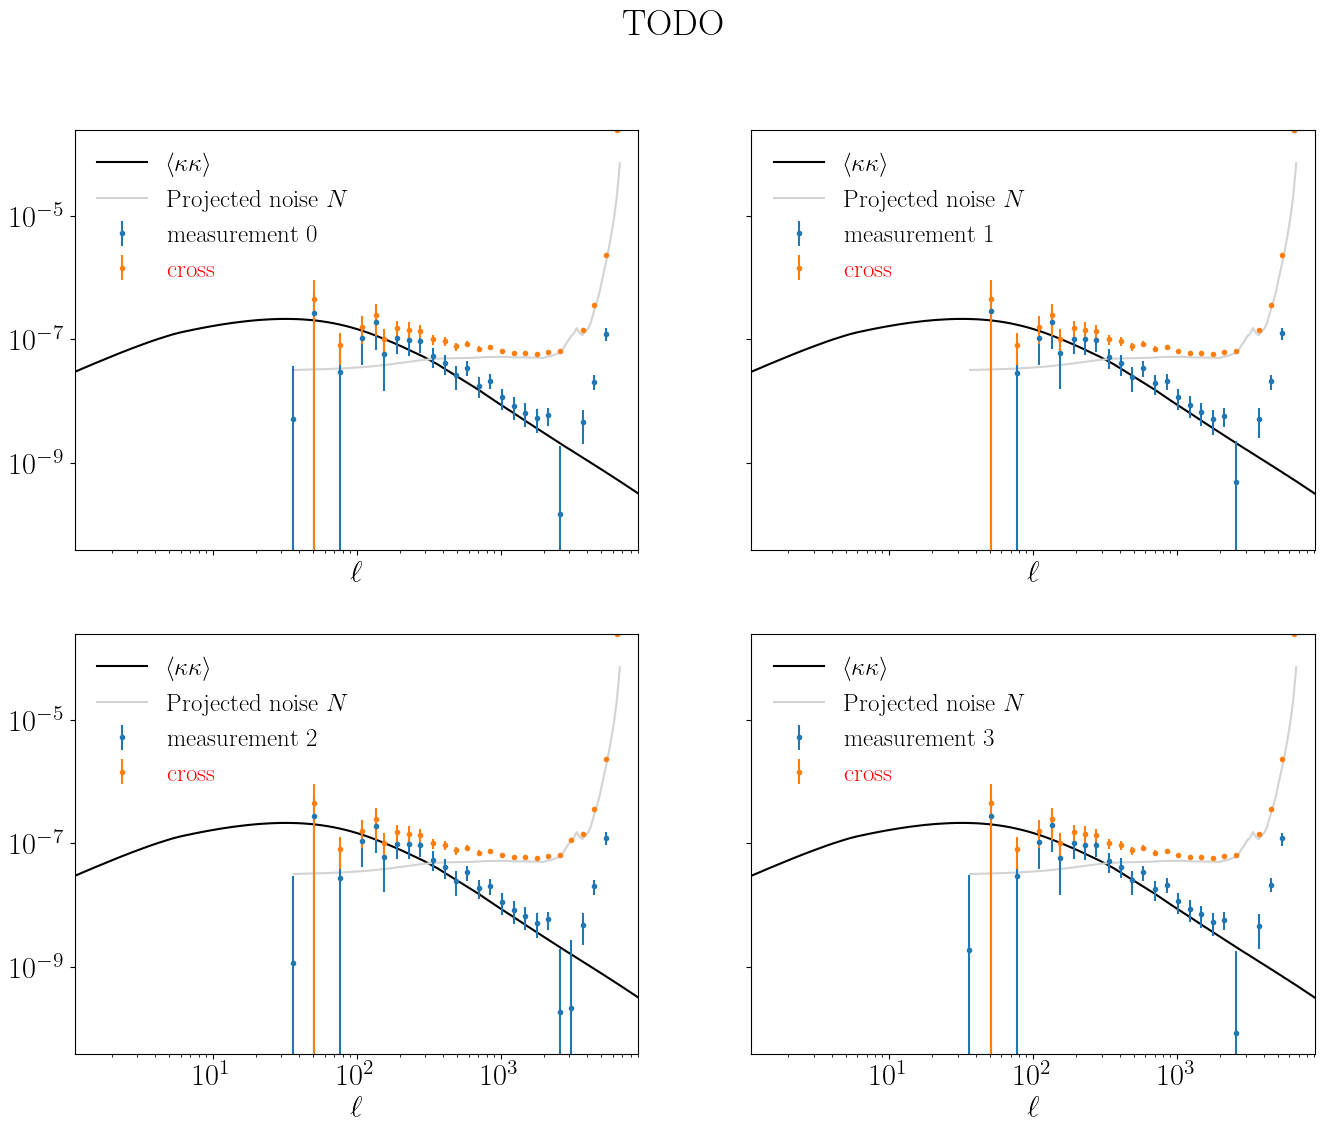

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,12), sharey=True, sharex=True)

ell = baseMap.l.flatten()
factor = 1. # lCen**2

theory=[p2d_cmblens.fPinterp, fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$', r'Projected noise $N$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for i in range(2):
        for j in range(2):
            
            axs[i][j].plot(L, factor*ClExpected, sty, label=l)

bnds = {'x':[],'y':[]}


for i in range(2):
    for j in range(2):
        key = 'measurement %d'%(i*2+j)
        lCen, Cl, sCl = Cls[key]

        Ipos = np.where(Cl>=0.)
        Ineg = np.where(Cl<0.)

        fctr = factor
        ax = axs[i][j]

        ax.errorbar(lCen[Ipos], factor*Cl[Ipos], yerr=factor*sCl[Ipos],fmt='.', label=key)

        lCen, Cl, sCl = Cls['cross']
        ax.errorbar(lCen[Ipos], factor*Cl[Ipos], yerr=factor*sCl[Ipos],fmt='.', label='cross')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\ell$')


        bnds['x'] += [np.min(lCen), np.max(lCen)]
        bnds['y'] += [factor*np.min(Cl), factor*np.max(Cl)]
    
    
fig.suptitle(r'TODO')

for i in range(2):
    for j in range(2):
        ax = axs[i][j]

        ax.set_xlim(np.min(bnds['x']), np.max(bnds['x']))
        ax.set_ylim(np.min(bnds['y']), np.max(bnds['y']))



        l=ax.legend(frameon=False, loc='upper left')
        l.get_texts()[-1].set_color('red')